In [ ]:
# 뉴스데이터 출처 - https://www.dropbox.com/sh/w4bh7hjkiw8jqmv/AACfhauVZuHLMkNxv7bWxeYia?dl=0

In [ ]:
'''
0. 데이터 불러오기 - 몽고디비 사용 X
0-1. 데이터 불러오기 - 일주일치 파일 -> 제목에 아파트가 있는 데이터만 csv파일로 저장함
0-2. apart_dataframe.csv 파일 열어서 사용



1. 제목에 '아파트' 가 들어있는 기사만 사용
2. 데이터 수집하기 << 진행중
2-1. 날짜에 따라 기사 건수를 저장해서 데이터 프레임을 만든다  -> 시각화해서 아파트가 언제 기사가 많이 나왔는지 확인
2-2. 텍스트의 빈도수를 가지고 있는 데이터 프레임을 만든다   -> 아파트와 연관 단어를 찾는다
3. EDA를 한다
4.

'''

In [ ]:
# .pkl은 피클이라는 파일이다
# pandas로 가져올 수 있음
# pd.read_pickle("파일명.pkl")  해서 불러올 수 있다.

In [ ]:
# 2023-08-14 ~ 2023-08-21 뉴스데이터 사용

### 0. 환경 설정

In [2]:
# 라이브러리 설정
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

'''
# 폰트 환경설정 - 구글 코랩 ========================
# matplotlib에서 한글 깨짐 문제 발생
# 한글 폰트 사용을 위해서 폰트 설치
# 참고 - https://www.whatwant.com/entry/matplotlib-hangul-colab-local
# 실행 후 런타임 다시 시작해야 함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


#설치한 폰트 사용
plt.rc('font', family='NanumBarunGothic')
'''



# 폰트 환경설정 - 주피터 노트북 ========================
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        font_family = "NanumBarunGothic"
    return font_family

# 시각화를 위한 폰트설정
# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당합니다.
import matplotlib.pyplot as plt

# ggplot으로 그래프 스타일 설정
plt.style.use("ggplot")

font_family = get_font_family()
# 폰트설정
plt.rc("font", family=font_family)
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)
# 그래프에 retina display 적용
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")


C:\Users\user\AppData\Local\Temp\ipykernel_14720\25648809.py:65: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


### 1. 함수 정의

#### 1-1. make_remove_text_list 함수 (제거할 텍스트가 담긴 리스트를 반환)

In [3]:
# 제거할 텍스트 키워드들이 들어있는 파일을 불러와서 리스트로 변환하기

def make_remove_text_list():
    filename = '제거키워드/remove_text_list.txt'
    tmp_data = open(filename, mode='r', encoding='UTF-8')
    tmp_data = tmp_data.read()
    tmp_data = tmp_data.replace("'","").replace("\n","").split(',')

    remove_text_list = []

    # 단어의 앞,뒤 띄어쓰기 제거
    for text in tmp_data:
        text = text.strip()
        remove_text_list.append(text)

    # 띄어쓰기와 쉼표를 remove_text_list에 추가
    remove_text_list.append(" ")
    remove_text_list.append(",")
    remove_text_list.append("'")
    remove_text_list.append('"')
    remove_text_list.append('정보,')


    remove_text_list = set(remove_text_list)
    return remove_text_list

#### 1-2. make_remove_ner_list 함수 (제거할 ner 종류가 담긴 리스트를 반환)

In [4]:
# 제거할 ner 구분 키워드들이 들어있는 파일을 불러와서 리스트로 변환하기

def make_remove_ner_list():
    filename = '제거키워드/remove_ner_list.txt'
    tmp_data = open(filename, mode='r', encoding='UTF-8')
    tmp_data = tmp_data.read()
    tmp_data = tmp_data.replace("'","").replace("\n","").split(',')

    remove_ner_list = []

    # 띄어쓰기 제거
    for text in tmp_data:
        text = text.strip()
        remove_ner_list.append(text)

    remove_ner_list = set(remove_ner_list)
    return remove_ner_list

#### 1-3. make_idxList, make_ners, make_apart_ners 함수

In [5]:
'''
'아파트' 가 제목에 포함된 뉴스기사의 인덱스를 idxList 리스트로 저장

'''
# 아파트 키워드가 제목에 포함된 뉴스기사의 인덱스를 idxList 리스트로 저장한다.
# 본문에 포함된 건 좀 광범위해서 제목에 포함된 것만 하기로 변경

def make_idxList(data):
    idxList = []

    for idx, title in enumerate(data.loc[:, 'title']):
        if title.find("아파트") != -1:
            idxList.append(idx)

    return idxList



# 인덱스리스트를 이용해서 ner을 추출한다.
def make_ners(data, idxList):
    ners = data.loc[idxList, 'ner']
    return ners


def make_apart_ners(data):
    idxList = make_idxList(data)
    apart_ners = make_ners(data, idxList)
    return apart_ners

#### 1-4.make_all_freq_result 함수

In [6]:
file = open('corp_type_230815_230821.txt', 'r', encoding='cp949')
corp_list = file.read()
corp_list = eval(corp_list)

In [7]:
'''
단어의 빈도수를 딕셔너리 형태로 저장
freq_result를 만드는 함수

예) {"아파트":5, "부동산":3, ... }

파라미터: apart_ners
리턴값: freq_result
'''

# end_words 리스트 안에 있는 단어가 나왔을 때 그 뒤에 나오는 단어는 저장되지 않음
# 정규표현식 사용해서 단어 여러개 중에 포함되면 그때 True로 바뀌게끔 하면 좋을 듯..
end_words = ['다음뉴스', '통신사.', '생각하시나요?', 'YTN', '타임톡beta', '타임톡', '저작권자', '경기일보', 'ⓒ', '한국일보', 'MBC뉴스', '제보하기', '세계일보', '헤럴드경제', 'Copyrightsⓒ', '다음뉴스를']
end_words = end_words + corp_list


def make_all_freq_result(apart_ners):

    #ner에서 단어들을 list_result에 넣기
    list_result = []
    for idx, ner in enumerate(apart_ners):
        end_word_yn = False
        for list in eval(ner):
            for tup in list:
                text = tup[0]
                type = tup[1]
                if (type not in remove_ner_list) & (text not in remove_text_list) & (len(text) > 1):
                    if text in end_words:
                        end_word_yn = True
                        break
                    else:
                        list_result.append(text)

            if end_word_yn == True:
                break


    freq_result = {}
    for w in list_result:
        #freq_result에 들어있지 않다면
        if w not in freq_result:
            freq_result[w] = 1
        #freq_result에 들어있다면
        elif w in freq_result:
            freq_result[w] += 1

    return freq_result

#### 1-5. make_day_freq_result 함수

In [8]:
'''
단어의 빈도수를 딕셔너리 형태로 저장
freq_result를 만드는 함수

예) {"아파트":5, "부동산":3, ... }

파라미터: apart_ners
리턴값: freq_result
'''

# end_words 리스트 안에 있는 단어가 나왔을 때 그 뒤에 나오는 단어는 저장되지 않음
# 정규표현식 사용해서 단어 여러개 중에 포함되면 그때 True로 바뀌게끔 하면 좋을 듯..
end_words = ['다음뉴스', '통신사.', '생각하시나요?', 'YTN', '타임톡beta', '타임톡', '저작권자', '경기일보', 'ⓒ', '한국일보', 'MBC뉴스', '제보하기', '세계일보', '헤럴드경제', 'Copyrightsⓒ', '다음뉴스를']
end_words = end_words + corp_list


dict_result = {}


def make_day_freq_result(data):

    apart_ners = make_apart_ners(data)

    #ner에서 단어들을 list_result에 넣기
    list_result = []
    for idx, ner in enumerate(apart_ners):
        freq_result = {}

        end_word_yn = False
        for list in eval(ner):
            for tup in list:
                text = tup[0]
                type = tup[1]
                if (type not in remove_ner_list) & (text not in remove_text_list) & (len(text) > 1):
                    if text in end_words: # 이 단어가 있으면 반복문을 끝내라
                        end_word_yn = True
                        break
                    else:
                        #freq_result에 들어있지 않다면
                        if text not in freq_result:
                            freq_result[text] = 1
                        elif text in freq_result:
                            freq_result[text] += 1

            if end_word_yn == True:
                break

        day = data.loc[idx].day
        day = str(day)

        tmp = {}
        tmp[day] = freq_result

        #dict_result에 같은 날짜가 있으면...
        if day in dict_result.keys():
            for sub_key in tmp[day]:
                if sub_key in dict_result[day]:
                    dict_result[day][sub_key] = dict_result[day][sub_key] + tmp[day][sub_key]
                    # print(cal)
                else:
                    dict_result[day][sub_key] = tmp[day][sub_key]
        else:
            dict_result[day] = tmp[day]


    return dict_result

#### 1-6. sort_dict_values 함수

In [9]:
# 딕셔너리를 value를 내림차순으로 출력
def sort_dict_values(dict):
    print(sorted(dict.items(), reverse=True, key= lambda item:item[1]))

### 2. 필요한 데이터 가공

#### 2-1. csv파일 저장

In [ ]:
#뉴스 데이터 데이터프레임 칼럼 특징

#url - 링크
#title - 뉴스 제목
#corp - 신문사 이름
#thumb - 썸네일 사진 링크
#day - 생성 일시
#time - 생성 시간
#category - 뉴스 카테고리
#img - 이미지 링크
#text - 텍스트로만 이뤄짐
#parsing - 파싱 데이터
#ner - 개체명 인식 데이터 (분류되어 있다.)

#ner 분류 참고 https://core.today/g/a0U1R29/c/M2dyhL492cp1o/f3V0jJ04y2

In [ ]:
# 데이터프레임을 불러와 하나의 데이터프레임으로 합친 후 csv에 저장


# 사용할 칼럼: ['title','text', 'parsing', 'ner', 'day']
# 데이터 불러올 때 오래 걸린다. 몇십분정도
data_0815 = pd.read_pickle("뉴스데이터/20230815.pkl")
data_0816 = pd.read_pickle("뉴스데이터/20230816.pkl")
data_0817 = pd.read_pickle("뉴스데이터/20230817.pkl")
data_0818 = pd.read_pickle("뉴스데이터/20230818.pkl")
data_0819 = pd.read_pickle("뉴스데이터/20230819.pkl")
data_0820 = pd.read_pickle("뉴스데이터/20230820.pkl")
data_0821 = pd.read_pickle("뉴스데이터/20230821.pkl")

data = pd.concat([data_0815, data_0816, data_0817, data_0818, data_0819, data_0820, data_0821], ignore_index=True)

#데이터프레임 합친 후 csv에 저장
idxList = make_idxList(data)
csv_data = data.loc[idxList,['title','text', 'parsing', 'ner', 'day']]
csv_data.to_csv("apart_dataframe.csv")

#기관 종류 중복없이 저장
corp_type = list(set(data.loc[:,'corp']))

#### 2-2. txt파일 저장

In [ ]:
#기관 종류 중복없이 텍스트파일로 저장
f = open(r'corp_type_230815_230821.txt', 'w')
f.write(str(corp_type))
f.close()

1244

#### 2-3. 함수 호출해서 변수 저장

In [10]:
# ✨ 저장한 csv 파일 불러와서 사용
data = pd.read_csv("apart_dataframe.csv")


# 함수 호출해서 변수에 저장

# (사회, O)  에서     0번 인덱스는 remove_text_list, 1번 인덱스는 remove_ner_list
# 1. remove_text_list : 제거할 텍스트 키워드
# 2. remove_ner_list : 제거할 ner 키워드

# 3. idxList : 아파트 키워드가 제목에 포함된 뉴스기사의 인덱스
# 4. freq_result : 단어의 빈도수 딕셔너리 / 예) {"아파트":5, "부동산":3, ... }


remove_text_list = make_remove_text_list()
remove_ner_list = make_remove_ner_list()
apart_ners = make_apart_ners(data)
# 기간동안 전체 단어의 건수
all_freq_result = make_all_freq_result(apart_ners)
# 날마다 단어의 건수
day_freq_result = make_day_freq_result(data)

### 3. 시각화

#### 3-1. 선그래프

In [ ]:
# ========================================================================
# ✨각 일자의 건수를 구해서 데이터프레임 만들고 선그래프 시각화하기

In [20]:
data = pd.read_csv("apart_dataframe.csv")
count_df = pd.DataFrame(data.groupby('day').count()['ner']).reset_index()
count_df.columns  = ['날짜', '언급기사건수']

In [21]:
count_df

,날짜,언급기사건수
0,20230815,72
1,20230816,148
2,20230817,163
3,20230818,111
4,20230819,28
5,20230820,53
6,20230821,125


In [23]:
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   날짜      7 non-null      int64
 1   언급기사건수  7 non-null      int64
dtypes: int64(2)
memory usage: 244.0 bytes


In [24]:
count_df = count_df.astype({'날짜':'str'})

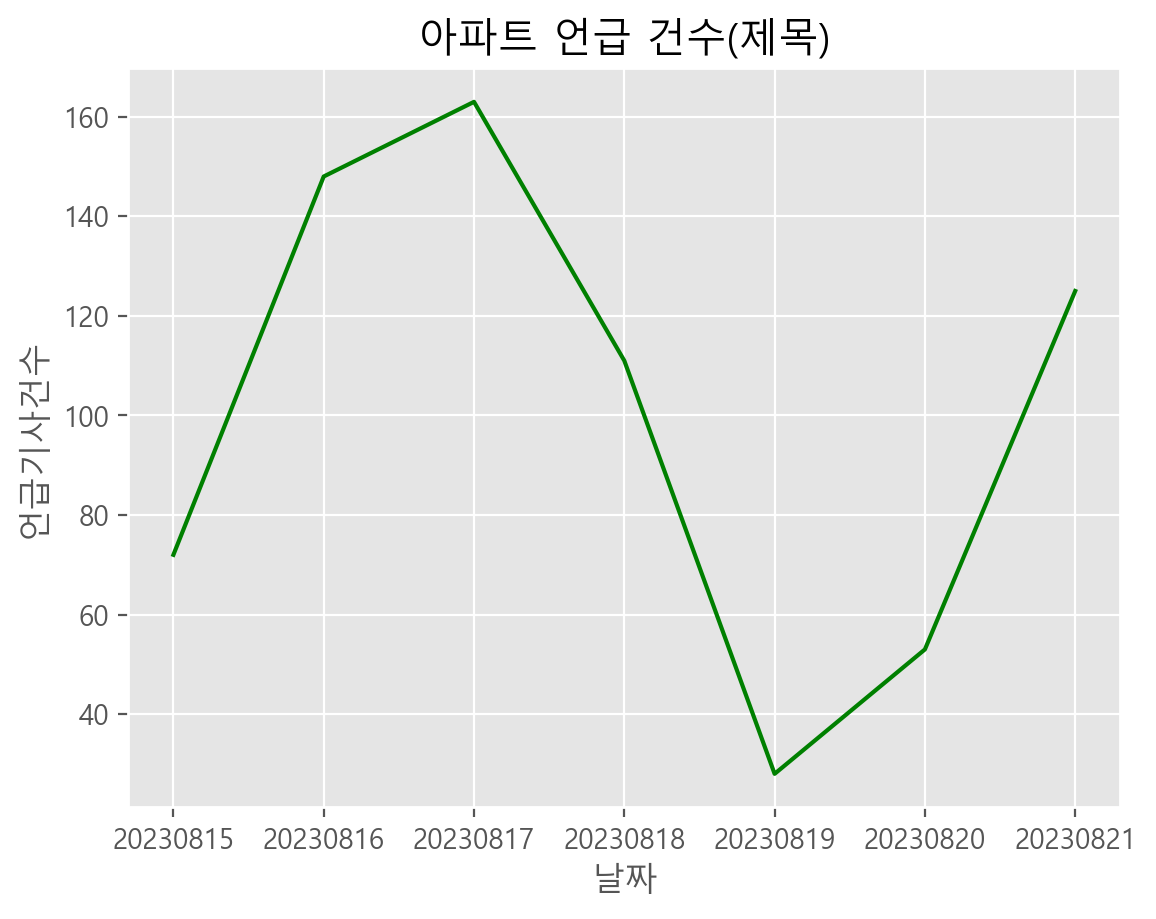

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

#plt.plot(df['언급기사건수'])
sns.lineplot(x='날짜', y='언급기사건수', data=count_df, color='green')
plt.title('아파트 언급 건수(제목)')
plt.show()

#### 3-2. 날짜별 트렌드 단어 그래프 - 막대, 누적막대

In [ ]:
# =======================================================
# ✨ 날짜별로 빈도수
# -> 갑자기 급등한 단어가 있는지!!
# Top 5 만 선그래프로 비교해보자!!!!!!

In [ ]:
day_freq_df.drop('아파트')

,20230815,20230816,20230817,20230818,20230819,20230820,20230821
경주,9.0,0.0,0.0,0.0,0.0,0.0,0.0
건설,4.0,12.0,1.0,2.0,0.0,3.0,4.0
구조물,1.0,0.0,0.0,0.0,0.0,0.0,0.0
와르르...,1.0,0.0,0.0,0.0,0.0,0.0,0.0
작업자,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
바라보며,0.0,0.0,0.0,0.0,0.0,0.0,1.0
무엇이,0.0,0.0,0.0,0.0,0.0,0.0,2.0
변했고,0.0,0.0,0.0,0.0,0.0,0.0,1.0
그대로인지,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
day_freq_df = pd.DataFrame(day_freq_result)
# 결측치 0으로 처리
day_freq_df[np.isnan(day_freq_df)] = 0
#day_freq_df = day_freq_df.reset_index()
day_freq_df = day_freq_df.drop('아파트')

day_freq_df.head()

,20230815,20230816,20230817,20230818,20230819,20230820,20230821
경주,9.0,0.0,0.0,0.0,0.0,0.0,0.0
건설,4.0,12.0,1.0,2.0,0.0,3.0,4.0
구조물,1.0,0.0,0.0,0.0,0.0,0.0,0.0
와르르...,1.0,0.0,0.0,0.0,0.0,0.0,0.0
작업자,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#언급이 많이 된 상위 10개의 단어를
#indexs 에 저장



# idx1 = day_freq_df['20230815'].sort_values(ascending=False)[0:10].index
# idx2 = day_freq_df['20230816'].sort_values(ascending=False)[0:10].index
# idx3 = day_freq_df['20230817'].sort_values(ascending=False)[0:10].index
# idx4 = day_freq_df['20230818'].sort_values(ascending=False)[0:10].index
# idx5 = day_freq_df['20230819'].sort_values(ascending=False)[0:10].index
# idx6 = day_freq_df['20230820'].sort_values(ascending=False)[0:10].index
# idx7 = day_freq_df['20230821'].sort_values(ascending=False)[0:10].index

idx1 = day_freq_df['20230815'].sort_values(ascending=False)[0:8].index
idx2 = day_freq_df['20230816'].sort_values(ascending=False)[0:8].index
idx3 = day_freq_df['20230817'].sort_values(ascending=False)[0:8].index
idx4 = day_freq_df['20230818'].sort_values(ascending=False)[0:8].index
idx5 = day_freq_df['20230819'].sort_values(ascending=False)[0:8].index
idx6 = day_freq_df['20230820'].sort_values(ascending=False)[0:8].index
idx7 = day_freq_df['20230821'].sort_values(ascending=False)[0:8].index


idx1 = list(idx1)
idx2 = list(idx2)
idx3 = list(idx3)
idx4 = list(idx4)
idx5 = list(idx5)
idx6 = list(idx6)
idx7 = list(idx7)


indexList = idx1 + idx2 + idx3 + idx4 + idx5 + idx6 + idx7
indexs = set(indexList)
#indexs

In [ ]:
often_df = day_freq_df.loc[indexs]
often_df.head()

<ipython-input-136-faff740af9f7>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  often_df = day_freq_df.loc[indexs]


,20230815,20230816,20230817,20230818,20230819,20230820,20230821
평균,3.0,45.0,5.0,1.0,1.0,3.0,1.0
부동산,1.0,18.0,44.0,11.0,3.0,3.0,17.0
한국부동산원,1.0,2.0,34.0,5.0,3.0,1.0,2.0
부모,0.0,0.0,6.0,8.0,7.0,0.0,0.0
서울,20.0,72.0,137.0,33.0,8.0,19.0,73.0


In [ ]:
often_df = often_df.reset_index()

In [ ]:
#df 만들기
def make_df(idx):
    df = ""
    df = day_freq_df.loc[idx]
    df = df.reset_index()
    df = pd.melt(df, id_vars=['index'], value_vars=often_df.columns[1:])

    return df

In [ ]:
df_0815[df_0815['variable']=='20230815']

,index,variable,value
0,경기도,20230815,28.0
1,서울,20230815,20.0
2,경비노동자,20230815,13.0
3,태극기,20230815,12.0
4,노동자,20230815,12.0
5,근로계약,20230815,9.0
6,수원,20230815,9.0
7,인권,20230815,9.0


In [ ]:
df_0815 = make_df(idx1)
df_0815 = df_0815[df_0815['variable']=='20230815']

df_0816 = make_df(idx2)
df_0816 = df_0816[df_0816['variable']=='20230816']

df_0817 = make_df(idx3)
df_0817 = df_0817[df_0817['variable']=='20230817']

df_0818 = make_df(idx4)
df_0818 = df_0818[df_0818['variable']=='20230818']

df_0819 = make_df(idx5)
df_0819 = df_0819[df_0819['variable']=='20230819']

df_0820 = make_df(idx6)
df_0820 = df_0820[df_0820['variable']=='20230820']

df_0821 = make_df(idx7)
df_0821 = df_0821[df_0821['variable']=='20230821']

Text(0.5, 0.98, '일자별 아파트 관련 단어 트렌드')

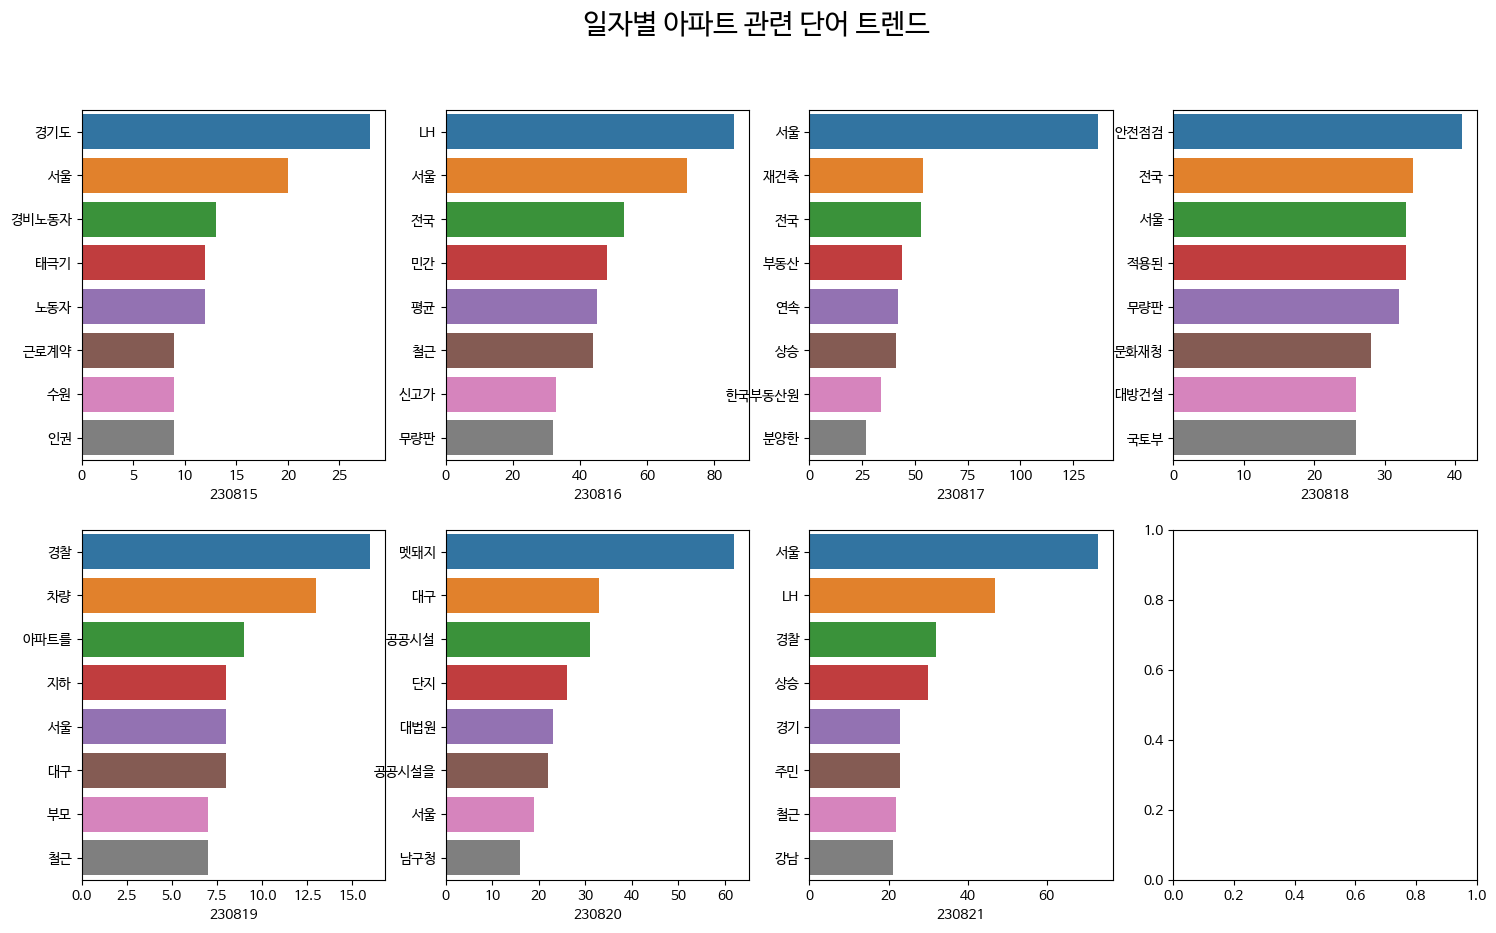

In [ ]:
fig, axis = plt.subplots(2, 4, figsize=(18,10))
axis = axis.flatten()

a1 = sns.barplot(y="index",  x="value", data=df_0815, ax=axis[0])
sns.barplot(y="index",  x="value", data=df_0816, ax=axis[1])
sns.barplot(y="index",  x="value", data=df_0817, ax=axis[2])
sns.barplot(y="index",  x="value", data=df_0818, ax=axis[3])
sns.barplot(y="index",  x="value", data=df_0819, ax=axis[4])
sns.barplot(y="index",  x="value", data=df_0820, ax=axis[5])
sns.barplot(y="index",  x="value", data=df_0821, ax=axis[6])

axis[0].set(ylabel="", xlabel="230815")
axis[1].set(ylabel="", xlabel="230816")
axis[2].set(ylabel="", xlabel="230817")
axis[3].set(ylabel="", xlabel="230818")
axis[4].set(ylabel="", xlabel="230819")
axis[5].set(ylabel="", xlabel="230820")
axis[6].set(ylabel="", xlabel="230821")

fig.suptitle('일자별 아파트 관련 단어 트렌드', fontsize=20)

[array(['경기도', '20230815', 28.0], dtype=object),
 array(['서울', '20230815', 20.0], dtype=object),
 array(['경비노동자', '20230815', 13.0], dtype=object),
 array(['태극기', '20230815', 12.0], dtype=object),
 array(['노동자', '20230815', 12.0], dtype=object),
 array(['근로계약', '20230815', 9.0], dtype=object),
 array(['수원', '20230815', 9.0], dtype=object),
 array(['인권', '20230815', 9.0], dtype=object)]

In [ ]:
# 누적막대그래프

In [ ]:
often_df = often_df.reset_index()
often_df.head(3)

In [ ]:
#내림차순 정렬
idx = often_df.sum(axis=1).sort_values(ascending=False)
often_df = often_df.loc[idx.index]

<ipython-input-156-bb1acf834346>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  idx = often_df.sum(axis=1).sort_values(ascending=False)


<Axes: >

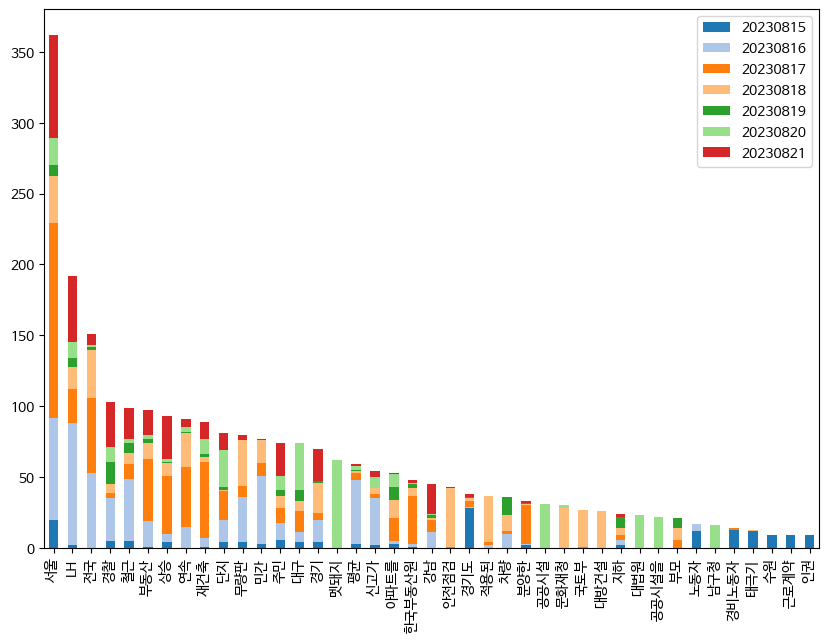

In [ ]:
word_list = list(often_df.loc[:,'index'] )
# 어울리는 팔레트 : Set2, tab20
colors = sns.color_palette('tab20',len(word_list))
often_df.plot.bar(x='index' ,stacked=True, figsize=(10,7), color=colors, xlabel='')


#### 3-3. 워드클라우드

In [ ]:
# ==========================================
# ✨ 워드클라우드 그리기

In [ ]:
# !pip install wordcloud


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
list(sort_dict_values(all_freq_result))

In [ ]:
# 워드클라우드에서 아파트 제거하기
all_freq_result.pop('아파트', None)

958

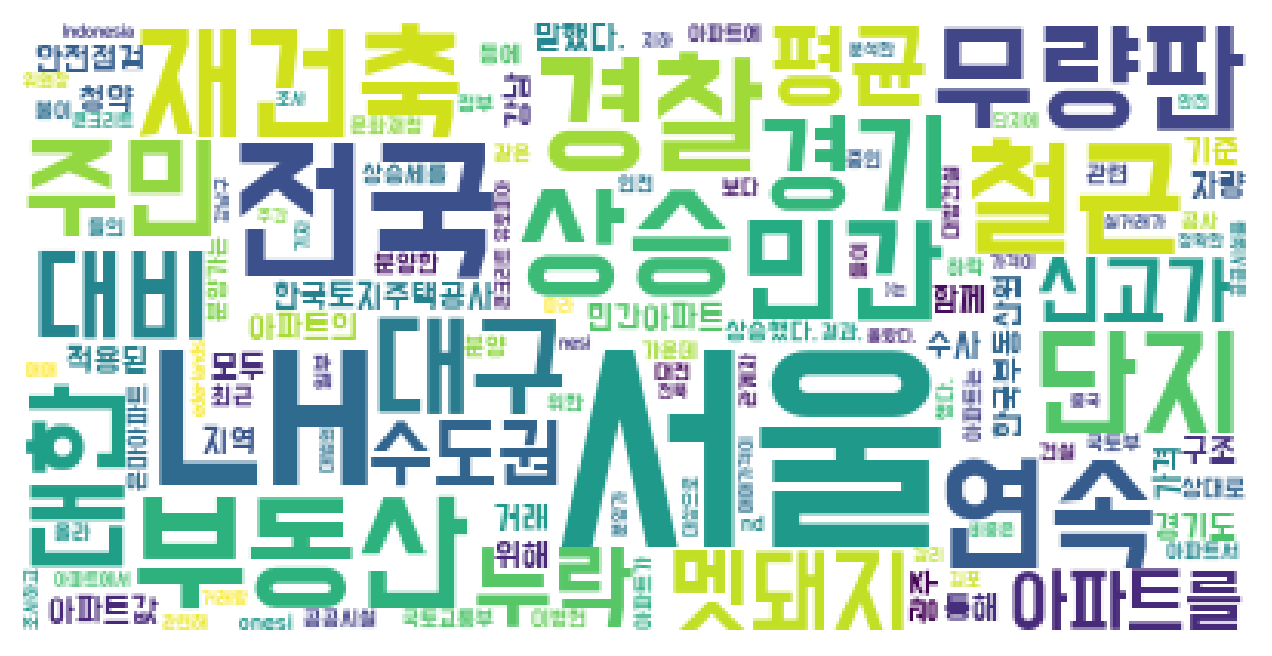

In [ ]:
# 이상한 데이터들이 많이 있다.. 전처리를 더 해야겠다.
# 워드클라우드로 표현하기
from wordcloud import WordCloud

wc = WordCloud(font_path="BMDOHYEON_ttf.ttf" ,
               background_color = 'white')

#워드클라우드 사이즈 변경하기
plt.figure(figsize = (10,4))

plt.axis("off")
cloud = wc.generate_from_frequencies(all_freq_result)
plt.imshow(cloud)  #워드클라우드 보여주기

#### 3-4. 네트워크 연결망(NetworkX)

In [ ]:
often_df['합계'] = often_df.sum(axis=1)

<ipython-input-214-f49011653346>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  often_df['합계'] = often_df.sum(axis=1)


In [ ]:
sum_often_df = often_df.loc[:,['index','합계']]
sum_often_df.head(2)

,index,합계
4,서울,362.0
14,LH,192.0


In [ ]:
import networkx as nx

In [ ]:
g1 = nx.Graph()
g2 = nx.DiGraph()

In [ ]:
g1.add_node("아파트")

In [ ]:
g1.add_node("4", node_size=800)

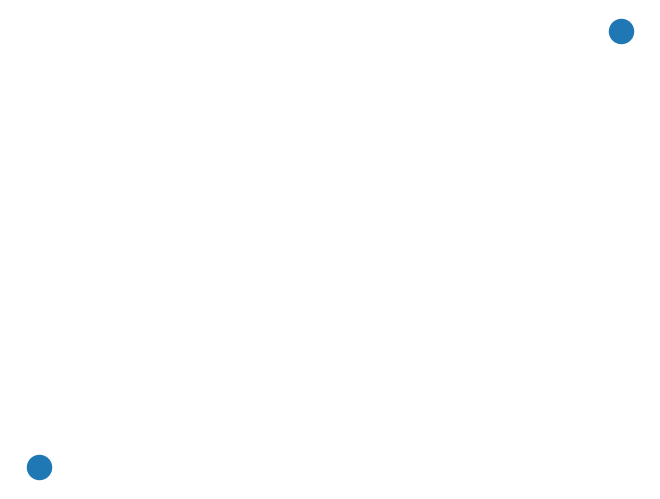

In [ ]:
nx.draw(g1)

In [ ]:
for row in sum_often_df.itertuples():
    g1.add_node(row[1])  #서울, LH 등등
    g1.add_edge("아파트",row[1])

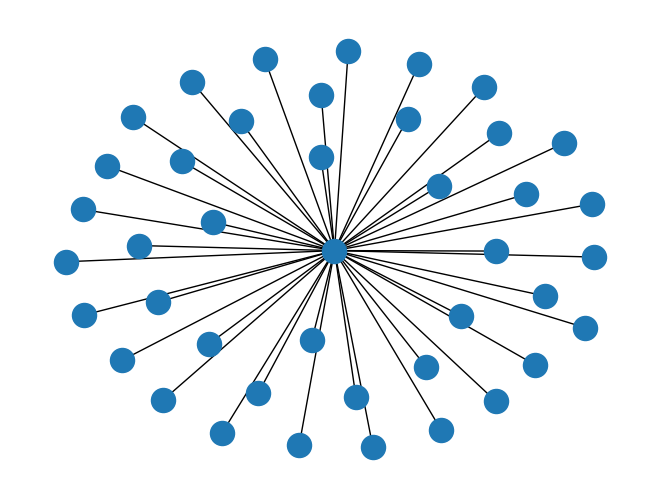

In [ ]:
nx.draw(g1)

In [ ]:
g1.add_node(1)            # 생성한 g1그래프에 노드 1을 생성(추가)

g1.add_node("a")       # 생성한 g1그래프에 노드 "a"를 생성(추가)

g1.add_nodes_from( [2, 7, 3] )      # 생성한 그래프에 노드 2, 7, 3을 생성(추가)


In [ ]:
g1.add_edge(1,"a")   # 노드 1과 "a"를 연결하는 Edge를 생성(추가)

g1.add_edge(2,7)     # 노드 2와 7을 연결하는 Edge를 생성(추가)

g1.add_edges_from( [ (2,7), (1,"a")] )     # 노드 2와 7을 연결하는 Edge, 노드 1과 "a"를 연결하는 edge를 생성

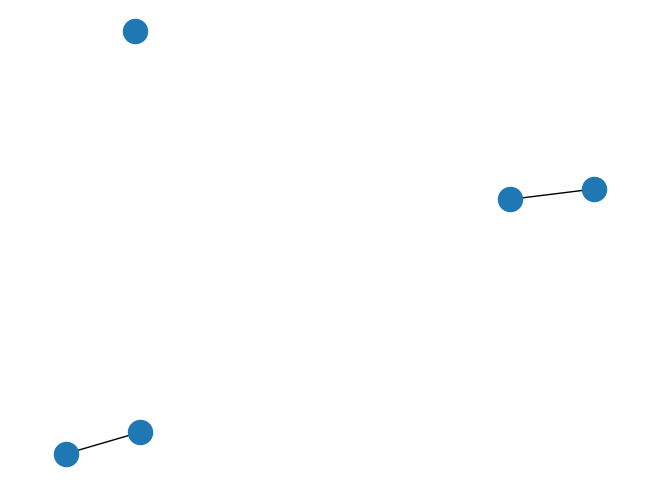

In [ ]:
nx.draw(g1)

In [ ]:
#networkX 참고
#레이아웃 참고: https://brain-nim.tistory.com/61

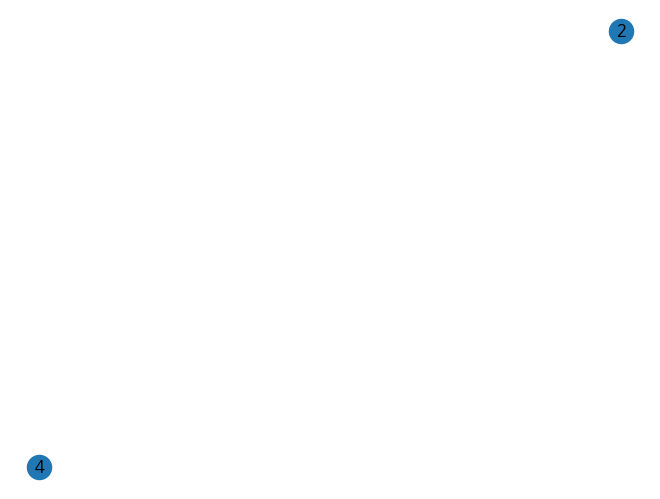

In [ ]:
pos = nx.kamada_kawai_layout(g1)
nx.draw(g1, pos, with_labels=True, font_family='NanumBarunGothic',)

### 언론사별로 본문만 추출하기 - 일단 패스

In [ ]:
# ==================================================================

# 패스함!!!!

In [ ]:
'''
언론사별로 본문만 추출하기 - 일단 패스

사실 본문만 추출하려고 하지 않아도 관련 기사의 경우에는 빈도수가 적을 것 같기는 하다..

'''

In [ ]:
# 언론사별로 본문이 아닌 내용이 있는게 많은데... 이것들을 어떻게 제거해야하는지 ...
# 언론사가 123개라서 언론사마다 다르기 때문에 이거는 일단 그냥 넘기기
len(set(data.corp)) #123

123

In [ ]:
data.iloc[1223]

url                    https://v.daum.net/v/20230819083600263
title                       대구 아파트 지하 2층 주차장에서 차량화재…40분 만에 완진
corp                                                      SBS
thumb       https://img1.daumcdn.net/thumb/S95x77ht.u/?fna...
day                                                  20230819
time                                                    08:36
category                     [{'cat1': '사회', 'cat2': '사회일반'}]
img         https://img1.daumcdn.net/thumb/R658x0.q70/?fna...
text        사회 대구 아파트 지하 2층 주차장에서 차량화재…40분 만에 완진 입력 2023. ...
parsing     {'parsing_NN': {'title': ['대구', '아파트', '지하', '...
ner         [[(사회, O), ( , O), (대구, LOCATION), ( , O), (아파...
Name: 1223, dtype: object

In [ ]:
#위쪽만 가져와야 할듯...
#밑에 부분에 관련 기사도 나온 것 같다
# idx = 99 인 경우에는 23~30번이 내용과 다른 부분  (corp = '머니투데이')
# idx = 216 인 경우에는 4~13번이 내용과 다른 부분  (corp = '이데일리')

for idx in idxList:
    row = data.iloc[idx]
    ner = row.ner
    for list in ner:
        for tup in list:
            if tup[1] != 'O':
                #print(tup)
    break

('경찰', 'ORGANIZATION')
("'순살공법", 'THEORY')
('4곳', 'QUANTITY')
('2023. 8. 19. 16:27', 'TIME')
('경찰', 'ORGANIZATION')
('한국토지주택공사', 'ORGANIZATION')
('LH', 'ORGANIZATION')
('19일', 'DATE')
('경찰', 'ORGANIZATION')
('경기북부경찰청', 'ORGANIZATION')
('LH', 'ORGANIZATION')
('무량판공법', 'CIVILIZATION')
('건설기술진흥법', 'CIVILIZATION')
('건축법', 'CIVILIZATION')
('주택법', 'CIVILIZATION')
('LH', 'ORGANIZATION')
('GS건설', 'ORGANIZATION')
('무량판공법', 'THEORY')
('순살 공법', 'THEORY')
('한국어', 'CIVILIZATION')
('영어', 'CIVILIZATION')
('日', 'CIVILIZATION')
('일본어', 'CIVILIZATION')
('중국어', 'CIVILIZATION')
('네델란드어', 'CIVILIZATION')
('독일어', 'CIVILIZATION')
('러시아', 'CIVILIZATION')
('말레이시아어', 'CIVILIZATION')
('벵골', 'CIVILIZATION')
('베트남어', 'CIVILIZATION')
('스페인어', 'CIVILIZATION')
('아랍어', 'CIVILIZATION')
('이탈리아어', 'CIVILIZATION')
('Indone', 'CIVILIZATION')
('인도네시아어', 'CIVILIZATION')
('태국어', 'CIVILIZATION')
('터키', 'CIVILIZATION')
('포르투갈어', 'CIVILIZATION')
('프랑스어', 'CIVILIZATION')
('힌디', 'CIVILIZATION')
('좌우', 'TERM')
('다음뉴스', 'TERM')
('다음

In [ ]:
ner = data.iloc[1016].ner
print(len(ner))

result = []
for list in ner:
        for tup in list:
            if (tup[1] not in remove_ner_list) & (tup[0] not in remove_text_list):
                result.append(tup[0])

21


In [ ]:
ner[14]
#인덱스번호 / 필요없는 인덱스 / 언론사 이름
#558 / 26-35 / 경기일보
#1016 / 14-21 / SBS
#1161 / 8-18 / KBS
#1223 / 14-22 / SBS
print()